# 오토인코더


오토인코더는 input 을 output으로 복사함으로써 학습한다.( input 과 output 모두 input과 동일한 값이다. ) 

단, 신경망은 범용근사자 (ubniversal function approximator ) 로서 근사치를 출력하기 때문에 x와 똑같은 출력을 내기 힘들다.
입력된 x를 '복원'한다는 개념이 더 알맞다. 그러므로 오차값에도 x를 얼마나 복워냈는지를 뜻하는 복원오차, 혹은 정보손실값 (reconstruction loss)라는 용어를 사용한다. 

오토인코더의 또 다른 중요한 특징은 입력과 출력의 크기가 같으나 중간으로 갈수록 신경망의 차원이 줄어든다.
이러한 모래시계 같은 구조로 정보의 통로가 줄어들기 때문에 병목현상이 일어나 입력의 특징이 압축되도록 학습된다.

작은 차원에 고인 압축된 표현을 잠재 변수라고 하고, 간단히 z라고도 한다.

또한 잠재 변수 앞부부은 인코더 뒷부분을 디코더라고 한다.

신겨앙이 받은 이미지를 복워나도록 학습하고 나면 잠재 변수엔 임지의 정보가 저장되낟.
낮은 차원에 높은 밀도로 표현된 데이터이미로 '의미의 압축'이 일어난다.
의미의 압축은 'ZIP 압축' 같은 것이 아니다.
단순히 데이터의 크기를 줄이고 싶다면 기존 압축 알고리즈을 사용하는 편이 빠르고 안전하다. 오토 인코더는 잠재 변수에 복잡한 데이터의 의미를 담을 수 있다는 저에서 특별하다.

정보를 압축할 수 있다는 것은 결국 정보의 구성에 우선순위가 있다는 것이다. 즉, 배경색과 같은 덜 중요한 요소는 버린다는 것이다. 이는 정보의 손실을 필연적으로 가져 온다. 고로 원본 데이터의 디테일은 잃어버리나 중요한 정보만 남겨두는 데이터 가공이라고 볼 수 있다.

이런 특징으로 인해 오토인코더는 주로 복잡한 비선형 데이터의 차원을 줄이는 용도로 사용된다. 그리고 비정상 거래 검출, 데이터 시각화와 복원, 의미 추출, 이ㅣ지 검색 등에도 사용되며 기계 번역과 생성 모델 등 여러가지 파생 모델에 응용되고 있다. 


# 필수 라이브러리 임포트


In [1]:
import torch 
import torchvision
import torch.nn.functional as F
from torch import nn,optim
from torchvision import transforms, datasets


# 모듈 임포트

matplotlib.pyplot -> 이미지 추적 : 오토인코더의 생성 이미지 관찰 
Axes3D -> 맷플롯립에서 3차원 플롯을 그림
cm -> 데이터 포인터에 색상을 입힘
numpy -> 행렬 변환 

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

# 하이퍼파라미터 

In [3]:
EPOCH = 10 
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Using Device: ", DEVICE)

Using Device:  cpu


# Fasion MNIST 데이터셋 로딩 

학습 데이터셋


In [4]:
trainset = datasets.FashionMNIST(
    root = './.data',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2 
)


# AutoEncoder 모듈 정의

인코더와 디코더를 모두 정의하는데 nn.Sequential를 이용해서 하나의 모듈로 묶어준다.
nn.Sequential은 여러 모듈을 하나의 모듈로 묶는 역할을 한느데 각 레이어를 데이터가 순차적으로 지나갈 때 사용하면 코드를 간결하게 만들 수 ㅇㅆ다. 계층과 활성화 함수를 정의해 주면 순서대로 값을 전달해 처리


인코더 (784 -> 128 -> 64 -> 12 -> 3) : 출력값은 encoded 
디코더 (3 -> 12 -> 64 -> 128 ->784) -> sigmoid() 함수 : 복원이미지 decoded 
출력값 0과 1 사이로 만들어주는 sigmoid()

In [25]:
class Autoencoder(nn.Module):
    def __init__ (self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64,12),
            nn.ReLU(),
            nn.Linear(12,3) 
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,28*28),
            nn.Sigmoid()
        )
        
    def forward (self, x):
        encoded = self.encoder(x)
        decoded = self.decoder (encoded)
        return encoded, decoded
    

# 모델과 최적화 함수 객체 호출 

최적화 함수는 Adam ( ) 으로 SGD 함수의 변형 함수이며 학습 중인 기울기를 참고해 학습속도를 자동으로 변화시킨다.

오차함수는 평균 제곱오차 함수인  MSELoss() 를 사용 


In [26]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr =0.005)
criterion = nn.MSELoss()

# 복원 확인
학습 데이터 셋에 있는 5개의 이미지를 가져와 모델에 바로 넣을 수 있도록 전처리를 하여 view_data에 넣는다.
255로 나누는 아ㅣ유는 픽셀의 색상값이 0부터 255까지 이므로 우리가 만드느는 모델이 인식하는 0부터 1 사이의 값으로 만들기 위함

In [27]:
view_data = trainset.data[:5].view(-1,28*28)
view_data = view_data.type(torch.FloatTensor)/255.

# 학습 함수

* 입력인 x와 대상 레이블인 y 모두 원본 이미지 (x) 

criterion = ( 디코더에서 나온 복원 이미지인 decoded - 원본 이미지 )^2 의 평균 
zero_grad() 기울기에 대한 정보를 초기화 
backward() 기울기 계산
optimizer.step() 최적화

In [28]:
def train( autoencoder, train_loader ):
    autoencoder.train()
    for step, (x,label) in enumerate(train_loader):
        x = x.view(-1,28*28).to(DEVICE)
        y = x.view(-1,28*28).to(DEVICE)
        label = label.to(DEVICE)
        
        encoded, decoded = autoencoder(x)
        
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

# 학습실행 및 과정 시각화 


 test_x 에 원본 이미지 저장 
 decoded_data 에 복원 이미지 저장 
 
 plt.subplots(2, 5, figsize = (5,2)) 함수로 
 2줄 5칸의 액자를 구성
 
 첫번째 줄 : 원본 이미지  5개
 두번째 줄 : 복원 이미지 5개 
 

 np.reshape(view_data.data.numpy()[i],(28,28)) 
 : 맷플롯립은 파이토치 텐서를 지원하지 않기 때문에 넘파이 행렬로 변환 
 회색조 색상 사용 : cmap = 'gray'
 
 CUDA를 사용하면 모델의 출력값이 아직 GPU에 나아 있다 
 따라서 .to("cpu") 를 사용해 일반 메모리로 가져온 후 
 .numpy() 함수를 사용해 넘파이 행렬로 변환 
 
 CPU 를 사용할 때도 같은 코드를 사용해도 무방
 
 변환한 이미지도 순서대로 액자의 두 번쨰 줄에 넣는다. 

[Epoch 1]


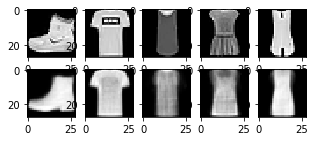

[Epoch 2]


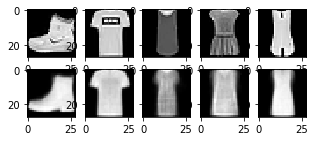

[Epoch 3]


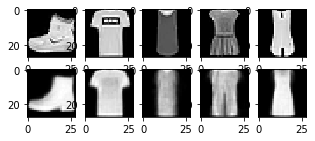

[Epoch 4]


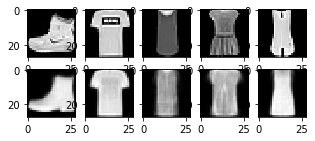

[Epoch 5]


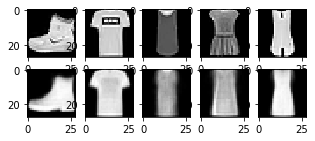

[Epoch 6]


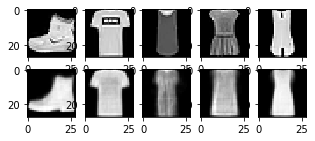

[Epoch 7]


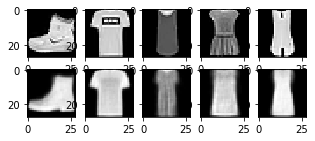

[Epoch 8]


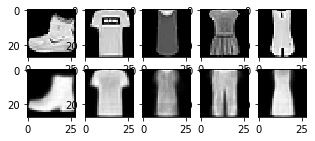

[Epoch 9]


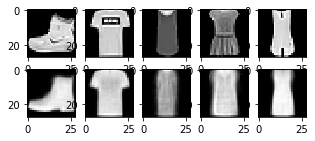

[Epoch 10]


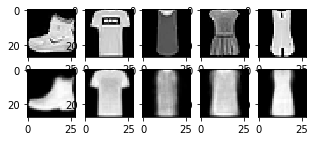

In [36]:
for epoch in range(1, EPOCH+1):
    # 학습 함수에 모듈과 데이터셋 로더 입력 
    train (autoencoder, train_loader)
    
    # 시각화를 위해 남겨둔 5개의 이미지를 한 이폭만큼의 학습을 마틴 모델에 넣어 복원 이미지를 만든다. 
    test_x = view_data.to(DEVICE) 
    _, decoded_data = autoencoder(test_x)
    
    # 원본과 디코딩 결과 비교하기 
    f,a = plt.subplots(2, 5, figsize = (5,2))
    print("[Epoch {}]".format(epoch))
    
    for i in range (5):
        img = np.reshape(view_data.data.numpy()[i],(28,28))
        a[0][i].imshow(img, cmap = 'gray')
        
    for i in range(5):
        img = np.reshape(decoded_data.to("cpu").data.numpy()[i],(28,28))

        a[1][i].imshow(img, cmap = 'gray')
    
    plt.show() # 이폭마다 이미지 출력 

# 잠재 변수 들여다 보기 

같은 레이블을 가진 이미지의 잠재 변수는 확연히 서로 모인다.
-> 비슷한 의미의 이미지라면 공간적으로 더 가깝다.

In [50]:
# 잠재 변수를 3d 플롯으로 시각화 하기 
view_data = trainset.data[:200].view(-1,28*28) # 학습 데이터 셋으로 부터 원본 이미지 200개를 ㅓㄷ음 
view_data = view_data.type(torch.FloatTensor)/255
test_x = view_data.to(DEVICE) # device로 원본 이미지를 보내 고 
encoded_data,_ = autoencoder(test_x)  #autoencode의 encoded 값을 encoded_data에 담는다. 
encoded_data = encoded_data.to("cpu") # encoded_data 값을 cpu로 보낸다. 


잠재 변수 레이블 딕셔너리 준비 

In [51]:
CLASSES = {
    0: 'T-shirt/top',
    1: 'Trouser',
    2: 'Pullover',
    3: 'Dress',
    4: 'Coat',
    5: 'Sandal',
    6: 'Shirt',
    7: 'Sneaker',
    8: 'Bag',
    9: 'Ankle boot'
}

zip 함수는 같은 길이의 행려들을 모아 순서대로 묶는다.
[1,2,3] 과 [a,b,c] 두 행렬을 zip 함수의 인수로 전달
-> [1,a],[2,b],[3,c] 순서로 출력 

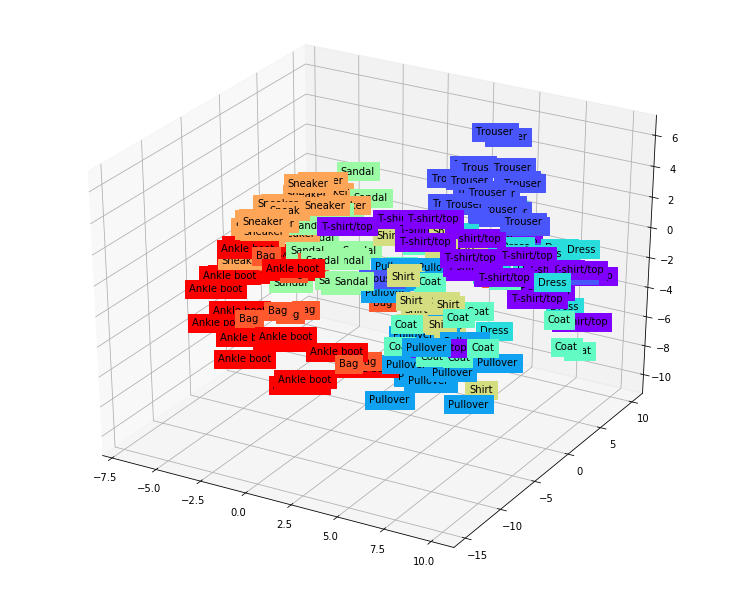

In [52]:

fig = plt.figure(figsize=(10,8))
# 3차원 액자 생성 
ax = Axes3D(fig)

# 넘파이 행렬로 변환
X = encoded_data.data[:, 0 ].numpy()
Y = encoded_data.data[:, 1 ].numpy()
Z = encoded_data.data[:, 2 ].numpy()
labels = trainset.targets[:200].numpy()

for x,y,z,s in zip(X,Y,Z,labels): 
    name = CLASSES[s]
    color = cm.rainbow(int(255*s/9))
    ax.text(x,y,z, name, backgroundcolor = color)
    
# 액자의 최솟값과 최댓갑 지정 
ax.set_xlim(X.min(), X.max())
ax.set_ylim(Y.min(), Y.max())
ax.set_zlim(Z.min(), Z.max())
plt.show()